# Cyberbullying On Social Media

# Feature Engineering

In [1]:
# dependencies
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import Counter

import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import seaborn as sns 

from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.decomposition import PCA


import gensim
from gensim.models.doc2vec import TaggedDocument

import multiprocessing

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('labeled_insta_cleaned.csv', encoding='utf-8-sig', engine='python')

In [3]:
comments = df['tidy_text']
labels = df['label_bullying']

In [4]:
wpt = nltk.WordPunctTokenizer()
tokenized_comments = [wpt.tokenize(comment) for comment in comments]

**Feature Extraction from Text**

To analyse a preprocessed data, it needs to be converted into features. Since numerical features ease the processing and statistical analysis, most machine learning algorithms require a numerical representation of objects as features. For this reason, feature extraction techniques are employed to convert the textual data into numerical features. The most popular and simple methods of feature extraction with text data currently used are:

- Bag of Words
- TF-IDF
- Word embeddings


***

More recently, new feature extraction techniques have been applied based on word embeddings (also known as word vectors). This kind of representations makes it possible for words with similar meaning to have a similar representation, which can improve the performance of classifiers. Word embedding is the modern way of representing words as vectors. The aim of word embedding is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus.

**Word2Vec**

Word2Vec is a group of related shallow, two-layer neural networks used to produce word embeddings. Word2Vec produces word embeddings based on the contextual semantics of words in a text (based on the context that the word occurs in). Words with similar linguistic contexts are mathematically grouped together in a vector space, which preserves the semantic relationship between words. Word2Vec can then use these word embeddings to produce predictions on a word’s meaning.

https://arxiv.org/pdf/1301.3781.pdf


Word embeddings provide a dense representation of words and their relative meanings. They are an improvement over sparse representations. Word embeddings can be learned from text data and reused among projects. They can also be learned as part of fitting a neural network on text data.

***

**Word2Vec**

In [5]:
# Dimensionality of the feature vectors set to a lower value since the vocabulary is quite limited.
FEATURE_SIZE = 100

For training Word2Vec, I will use the whole data set. The rationale behind this is that the word2vec training is unsupervised and thus there is no need to hold out any data. 

Also, the same rationale has been applied in the Gensim's Word2Vec [tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py).

In [6]:
cores = multiprocessing.cpu_count() # Count the number of cores in the computer

w2v_model = gensim.models.Word2Vec(tokenized_comments, 
                                   size = FEATURE_SIZE, #Dimensionality of the feature vectors. Typical values (50, 300), depending on vocabulary size. 
                                   window = 5, #The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target.
                                   # Typical values are (2, 10).
                                   min_count = 100, #Ignores all words with total absolute frequency lower than this - (2, 100).
                                   workers = cores, 
                                   iter = 10 #Number of iterations (epochs) over the corpus. 5 is a good starting point. 
                                  )

This step was initially confusing in the beginning. I have seen many examples initializing the Word2Vec object without specifying the tokenized_comments. And later on they would call build_vocab() and train() as separate steps. While that is definitely one way of doing it, it seemed cleaner to do the initialization, vocabulary-building and training all together by passing the tokenized_comments as an object and number of training iterations into Word2Vec(), especially for this part.

I also initially had smaller min_count values. Smaller min_count mean a larger model, slower training, poor-quality vectors for words with just a few examples, and also counterintuitively worse-quality vectors for more-frequent words too, because of interference from the noisy rare words. According to my research, it seems to be better to ignore lowest-frequency words.

**A note on the dimensionality of the feature vectors:**

The number of dimensions reflects the over/under fitting. According to my research, 100-300 dimensions is the common knowledge. Typically one would start with one number and check the accuracy of your testing set versus training set. For a bigger dimension size, it will be easier to overfit on the training set and to have bad performance on the test. Tuning this parameter is required in case we have high accuracy on training set and low accuracy on the testing set, this means that the dimension size is too big and reducing it might solve the overfitting problem of the model. 

In [31]:
w2v_model.wv.most_similar("hate")

[('ignore', 0.49754607677459717),
 ('upset', 0.47396546602249146),
 ('bother', 0.41431567072868347),
 ('haters', 0.41416341066360474),
 ('larry', 0.406703382730484),
 ('them', 0.40443921089172363),
 ('perrie', 0.3778010308742523),
 ('ship', 0.37679505348205566),
 ('sometimes', 0.3719663918018341),
 ('reason', 0.3625146150588989)]

In [8]:
w2v_model.wv.most_similar("asshole")

[('cunt', 0.6770209670066833),
 ('idiot', 0.6077359914779663),
 ('gtfo', 0.6037980914115906),
 ('bitch', 0.5948122143745422),
 ('slut', 0.5947431325912476),
 ('faggot', 0.5936681032180786),
 ('retard', 0.5932586193084717),
 ('insult', 0.5883283019065857),
 ('whore', 0.5808143615722656),
 ('fucken', 0.5695441961288452)]

In [9]:
w2v_model.wv.most_similar("great")

[('awesome', 0.622880220413208),
 ('good', 0.6017042994499207),
 ('amaze', 0.5544376373291016),
 ('talented', 0.5146157741546631),
 ('role', 0.5073156356811523),
 ('inspire', 0.5053715705871582),
 ('enjoy', 0.4943687617778778),
 ('epic', 0.46706920862197876),
 ('congrats', 0.4565005898475647),
 ('nice', 0.4487471580505371)]

We see some nice similarities being found here, especially for the positive word, which is reflective of our corpus. Also for the negative words there are some interesting correlations being found (hate and ignore, for example).

Now let's build the word vectors for training, since we will need these vectors in predictive modeling. To use the embeddings, the word vectors need to be mapped. In order to convert a document of multiple words into a single vector using the trained model, it is typical to take the word2vec of all words in the document, then take its mean. What this functions does is rather simple: it transforms all tokens in the text into vectors and does the averaging to come up with representative word vector. If the word has no tokens, then it will return a zero vector.

In [10]:
# Build word vector for training 
# Code from: https://medium.com/district-data-labs/modern-methods-for-sentiment-analysis-694eaf725244
def word_vector(text):
    vec = np.zeros(FEATURE_SIZE).reshape((1, FEATURE_SIZE))
    count = 0.
    for word in text:
        try:
            vec += w2v_model[word].reshape((1, FEATURE_SIZE))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

w2v_arrays = np.concatenate([word_vector(z) for z in tokenized_comments])

In [11]:
w2v_arrays.shape

(11033, 100)

In [12]:
np.save("w2v_features.npy", np.array(w2v_arrays))

In [13]:
w2v_model.save("word2vec.model")

**Visualize Word2Vec embeddings**

Again, I will use t-SNE for visualization, using the same parameters as in the TF-IDF section. TSNE is a manifold learning technique which means that it tries to map high-dimensional data to a lower-dimensional manifold, creating an embedding that attempts to maintain local structure within the data. It’s almost exclusively used for visualization because the output is stochastic and it does not support transforming new data.

In [14]:
from sklearn.decomposition import TruncatedSVD
X_red = TruncatedSVD(n_components=50, random_state=0).fit_transform(w2v_arrays)

In [15]:
from  sklearn.manifold import TSNE
#Perplexity 10
X_tsne = TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(X_red)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 11033 samples in 0.033s...
[t-SNE] Computed neighbors for 11033 samples in 13.343s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11033
[t-SNE] Computed conditional probabilities for sample 2000 / 11033
[t-SNE] Computed conditional probabilities for sample 3000 / 11033
[t-SNE] Computed conditional probabilities for sample 4000 / 11033
[t-SNE] Computed conditional probabilities for sample 5000 / 11033
[t-SNE] Computed conditional probabilities for sample 6000 / 11033
[t-SNE] Computed conditional probabilities for sample 7000 / 11033
[t-SNE] Computed conditional probabilities for sample 8000 / 11033
[t-SNE] Computed conditional probabilities for sample 9000 / 11033
[t-SNE] Computed conditional probabilities for sample 10000 / 11033
[t-SNE] Computed conditional probabilities for sample 11000 / 11033
[t-SNE] Computed conditional probabilities for sample 11033 / 11033
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed con

Populating the interactive namespace from numpy and matplotlib


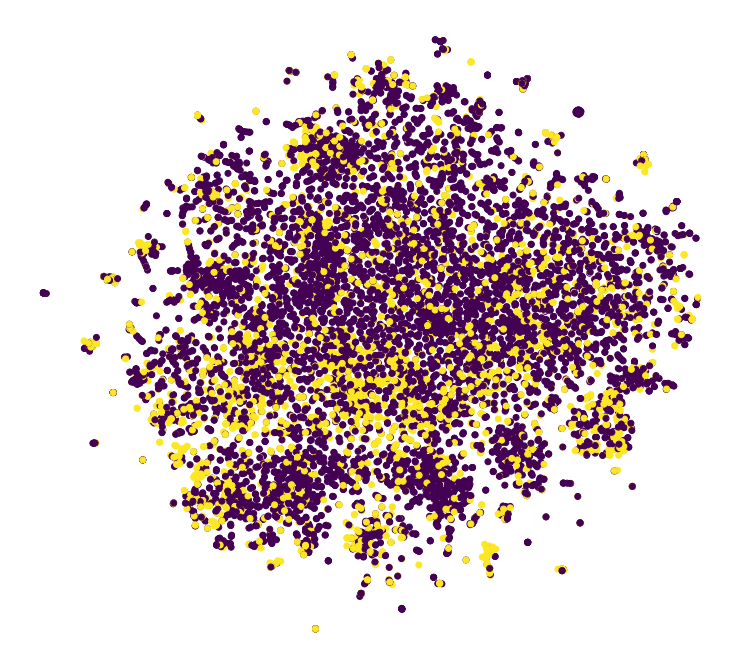

In [16]:
%pylab inline
figure(figsize=(10, 10))
ax = axes(frameon=False)
setp(ax, xticks=(), yticks=())
subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.0, hspace=0.0) 
scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)

In [17]:
#Perplexity 100
X_tsne = TSNE(n_components=2, perplexity=100, verbose=2).fit_transform(X_red)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 11033 samples in 0.042s...
[t-SNE] Computed neighbors for 11033 samples in 16.873s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11033
[t-SNE] Computed conditional probabilities for sample 2000 / 11033
[t-SNE] Computed conditional probabilities for sample 3000 / 11033
[t-SNE] Computed conditional probabilities for sample 4000 / 11033
[t-SNE] Computed conditional probabilities for sample 5000 / 11033
[t-SNE] Computed conditional probabilities for sample 6000 / 11033
[t-SNE] Computed conditional probabilities for sample 7000 / 11033
[t-SNE] Computed conditional probabilities for sample 8000 / 11033
[t-SNE] Computed conditional probabilities for sample 9000 / 11033
[t-SNE] Computed conditional probabilities for sample 10000 / 11033
[t-SNE] Computed conditional probabilities for sample 11000 / 11033
[t-SNE] Computed conditional probabilities for sample 11033 / 11033
[t-SNE] Mean sigma: 0.700893
[t-SNE] Computed co

Populating the interactive namespace from numpy and matplotlib


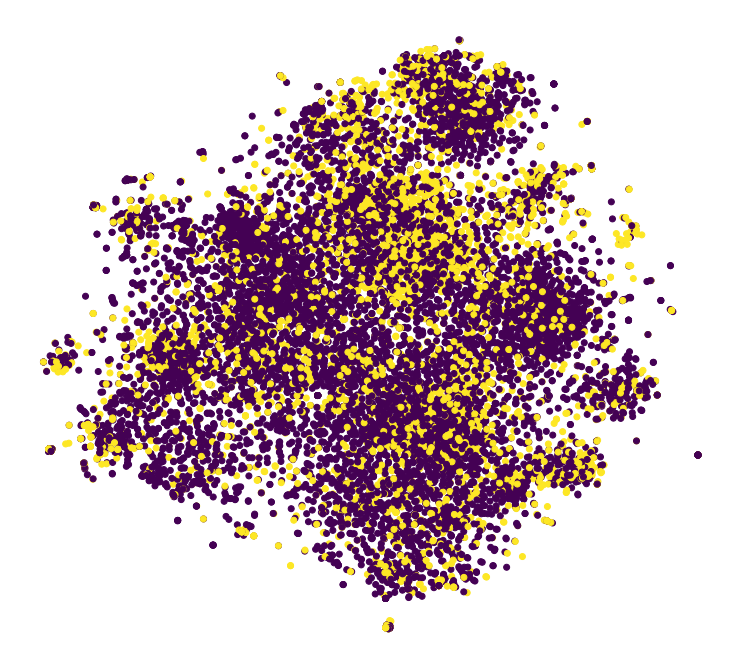

In [18]:
%pylab inline
figure(figsize=(10, 10))
ax = axes(frameon=False)
setp(ax, xticks=(), yticks=())
subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.0, hspace=0.0) 
scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)

The two classes do not look well separated, which could in theory be a feature of our embeddings or simply of our dimensionality reduction. Since we already know the classes are overlapping, we can safely say it's a feature of our embeddings.

Unlike TF-IDF, increasing the perplexity level makes no difference here. So it's time to try a different visualization technique.

***

**Visualize Word2Vec embeddings together with the labels**

In [19]:
vocab = list(w2v_model.wv.vocab)
X = w2v_model[vocab]

In [20]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [21]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

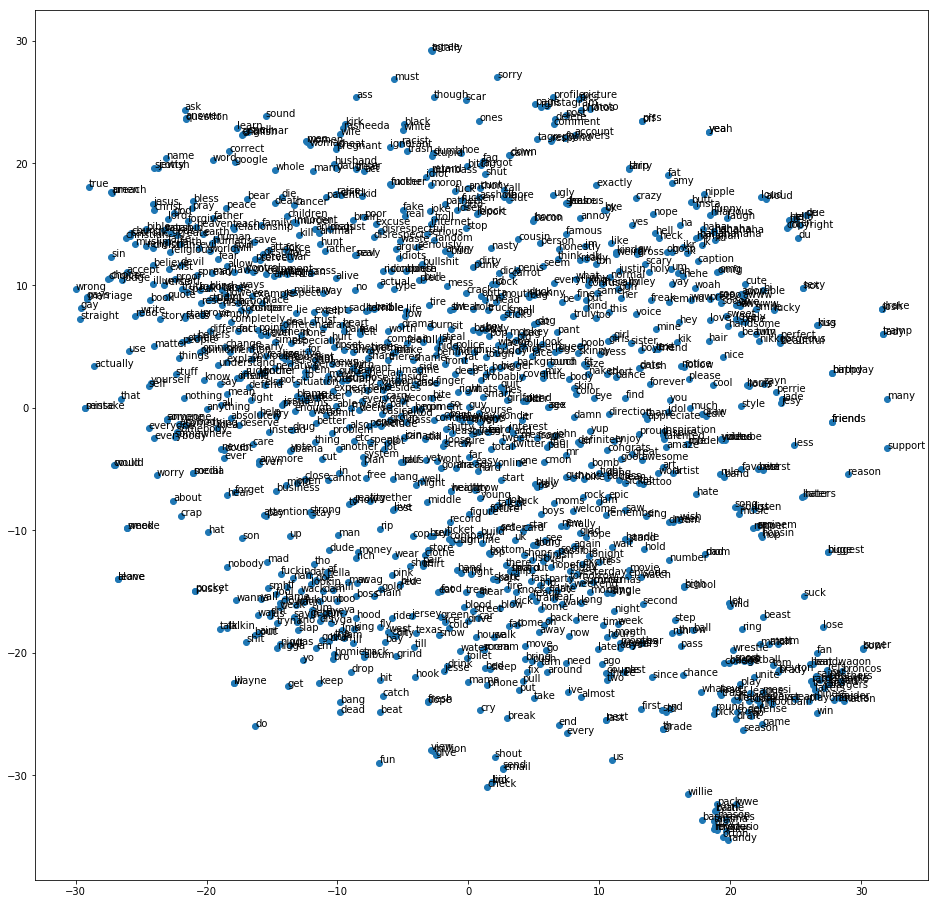

In [22]:
fig = plt.figure(figsize=(16, 16)) 
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)
plt.show()

It's not really possible to make any sense of the plot here due to the size of the corpus. It is time to try a different technique and reduce the data points to a couple of the most common negative words.

For the following part I've borrowed the code from https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

In [27]:
keys = ['fuck', 'asshole', 'shit', 'hate', 'bitch', 'damn', 'suck']

In [28]:
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.most_similar(word, topn=20):
        words.append(similar_word)
        embeddings.append(w2v_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [29]:
RANDOM_STATE=12
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne = TSNE(perplexity=100, n_components=2, init='pca', n_iter=1000, random_state=RANDOM_STATE)
embeddings_tsne = np.array(tsne.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

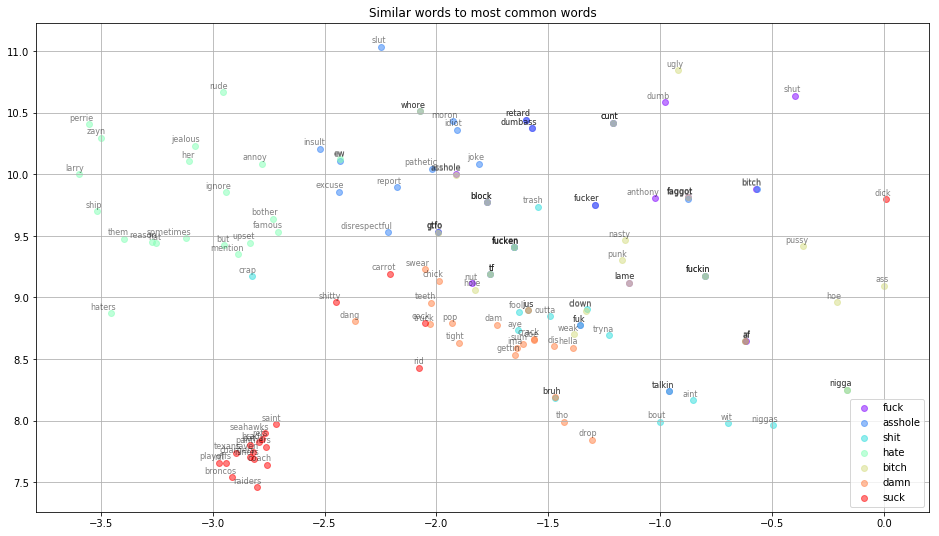

In [30]:
plt.figure(figsize=(16, 9))
colors = cm.rainbow(np.linspace(0, 1, len(keys)))
for label, embeddings, words, color in zip(keys, embeddings_tsne, word_clusters, colors):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    plt.scatter(x, y, c=np.array([color]), alpha=0.5, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
plt.legend(loc=4)
plt.title('Similar words to most common words')
plt.grid(True)
plt.show()

Here we notice some nice similarites for the most common bullying words in our corpus, as well the beginning of the formation of clusters.

It’s clear from the plot here that Word2Vec is able to learn non-trivial relationships between words (hate and jealous or rude, for example). This is what makes them powerful for many NLP tasks, and in our case sentiment analysis. 